In [1]:

import warnings
warnings.simplefilter("ignore")
import sys
import nibabel as nib
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mping
import skimage.io as io
import matplotlib.axes as maxes
# import nilearn.image as nl
import os
import os.path as op
#from ndmg.scripts import ndmg_dwi_pipeline

In [2]:
input_1 = r"/Users/xueminzhu/Desktop/test/tests_input/1.nii.gz"
input_2 = r"/Users/xueminzhu/Desktop/test/tests_input/2.nii.gz"
output_dir = r"/Users/xueminzhu/Desktop/test"

In [3]:
def _tile_plot(imgs, titles, **kwargs):
    """
    Helper function
    """
    # Create a new figure and plot the three images
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=1, hspace=1)
    fig, ax = plt.subplots(3, 3)
    k = 0
    for i in [0, 1, 2]:
        ax[0,0].set_ylabel('Sagittal(YZ fixed)')
        ax[1,0].set_ylabel('Coronal(XZ fixed)')
        ax[2,0].set_ylabel('Axial(XY fixed)')
        for j in [0, 1, 2]:
            #ax[i][j].set_axis_off()
            ax[i][j].imshow(imgs[k], **kwargs)
            ax[i][j].set_title(titles[k])
            k = k+1
    fig.tight_layout()
    return fig

In [4]:
def overlay_slices(L, R, slice_index=None, slice_type=1, ltitle='Left',
                   rtitle='Right', fname=None):
    r"""Plot three overlaid slices from the given volumes.
    Creates a figure containing three images: the gray scale k-th slice of
    the first volume (L) to the left, where k=slice_index, the k-th slice of
    the second volume (R) to the right and the k-th slices of the two given
    images on top of each other using the red channel for the first volume and
    the green channel for the second one. It is assumed that both volumes have
    the same shape. The intended use of this function is to visually assess the
    quality of a registration result.
    Parameters
    ----------
    L : array, shape (S, R, C)
        the first volume to extract the slice from, plottet to the left
    R : array, shape (S, R, C)
        the second volume to extract the slice from, plotted to the right
    slice_index : int (optional)
        the index of the slices (along the axis given by slice_type) to be
        overlaid. If None, the slice along the specified axis is used
    slice_type : int (optional)
        the type of slice to be extracted:
        0=sagital, 1=coronal (default), 2=axial.
    ltitle : string (optional)
        the string to be written as title of the left image. By default,
        no title is displayed.
    rtitle : string (optional)
        the string to be written as title of the right image. By default,
        no title is displayed.
    fname : string (optional)
        the name of the file to write the image to. If None (default), the
        figure is not saved to disk.
    """
    # Normalize the intensities to [0,255]
    sh = L.shape
    L = np.asarray(L, dtype=np.float64)
    R = np.asarray(R, dtype=np.float64)
    L = 255 * (L - L.min()) / (L.max() - L.min())
    R = 255 * (R - R.min()) / (R.max() - R.min())
    # Create the color image to draw the overlapped slices into, and extract
    # the slices (note the transpositions)
    if slice_type is 0:
        if slice_index is None:
            slice_index = sh[0] // 2
        colorImage = np.zeros(shape=(sh[2], sh[1], 3), dtype=np.uint8)
        ll = np.asarray(L[slice_index, :, :]).astype(np.uint8).T
        rr = np.asarray(R[slice_index, :, :]).astype(np.uint8).T
    elif slice_type is 1:
        if slice_index is None:
            slice_index = sh[1] // 2
        colorImage = np.zeros(shape=(sh[2], sh[0], 3), dtype=np.uint8)
        ll = np.asarray(L[:, slice_index, :]).astype(np.uint8).T
        rr = np.asarray(R[:, slice_index, :]).astype(np.uint8).T
    elif slice_type is 2:
        if slice_index is None:
            slice_index = sh[2] // 2
        colorImage = np.zeros(shape=(sh[1], sh[0], 3), dtype=np.uint8)
        ll = np.asarray(L[:, :, slice_index]).astype(np.uint8).T
        rr = np.asarray(R[:, :, slice_index]).astype(np.uint8).T
    else:
        print("Slice type must be 0, 1 or 2.")
        return
    # Draw the intensity images to the appropriate channels of the color image
    # The "(ll > ll[0, 0])" condition is just an attempt to eliminate the
    # background when its intensity is not exactly zero (the [0,0] corner is
    # usually background)
    colorImage[..., 0] = ll * (ll > ll[0, 0])
    colorImage[..., 1] = rr * (rr > rr[0, 0])
    return colorImage

In [5]:
def qa_align(inp_dir_reg, inp_dir_ref, out_dir):
    """
    inp_dir_reg: directory where output tmp image registered is saved
    inp_dir_ref: directory where input reference image is saved
    out_dir: directory where the final result is saved
    """
    # name new files
    new_name_reg = inp_dir_reg.split('/')[-1]
    new_name_ref = inp_dir_ref.split('/')[-1]
    # set the output file path of overlay_qa and nifti_result
    #out_dir_visual = "{}/qa/reg/".format(out_dir)
    #out_dir_tmp_align = "{}/qa/reg/".format(out_dir)+"{}".format(new_name_reg)
    #out_dir_tmp_ref = "{}/qa/reg/".format(out_dir)+"{}".format(new_name_ref)
    out_dir_visual = "{}/".format(out_dir)
    out_dir_tmp_align = "{}/".format(out_dir)+"{}".format(new_name_reg)
    out_dir_tmp_ref = "{}/".format(out_dir)+"{}".format(new_name_ref)
    
    # load input images of registration and reference
    img_tmp_align = nib.load(inp_dir_reg).get_data()
    img_tmp_ref = nib.load(inp_dir_ref).get_data()

    # save file
    #nib.save(img_tmp_align, out_dir_tmp_align)
    #nib.save(img_tmp_ref, out_dir_tmp_ref)
    
    # visualize using slicesdir
    # cmd = "slicesdir `imglob {}`".format(out_dir_tmp_align)
    # os.system(cmd)
    # fig = overlay_slices(img_tmp_ref, img_tmp_align, None, 0)
    shape = img_tmp_align.shape
    print(shape)
    #a = shape[0]//4
    imgs = []
    imgs.append(overlay_slices(img_tmp_ref, img_tmp_align, 40, 0) )
    imgs.append(overlay_slices(img_tmp_ref, img_tmp_align, 48, 0))
    imgs.append(overlay_slices(img_tmp_ref, img_tmp_align, 56, 0)) 
    imgs.append(overlay_slices(img_tmp_ref, img_tmp_align, 54, 1) )
    imgs.append(overlay_slices(img_tmp_ref, img_tmp_align, 64, 1))
    imgs.append(overlay_slices(img_tmp_ref, img_tmp_align, 74, 1)) 
    imgs.append(overlay_slices(img_tmp_ref, img_tmp_align, 54, 2) )
    imgs.append(overlay_slices(img_tmp_ref, img_tmp_align, 64, 2))
    imgs.append(overlay_slices(img_tmp_ref, img_tmp_align, 74, 2)) 
    return imgs

(91, 109, 91)


<function matplotlib.pyplot.show(*args, **kw)>

<Figure size 432x288 with 0 Axes>

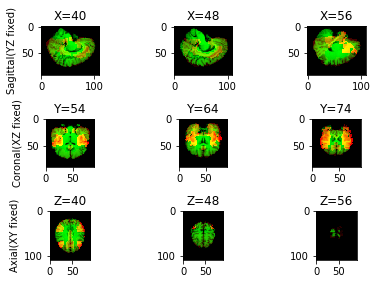

In [6]:
imgs = qa_align(input_1, input_2, output_dir)
_tile_plot(imgs,['X=40','X=48','X=56','Y=54','Y=64','Y=74','Z=40','Z=48','Z=56'])
#_tile_plot(imgs,['sagittal1''coronal1','axial1'])
plt.savefig('/Users/xueminzhu/Desktop/test/test.png')
plt.show